### 1. Ready to analysis

#### 1) import packages 

In [1]:
import pandas as pd
import numpy as np
import random as rd

import itertools
import os

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

#### 2) load dataset

In [2]:
# 1978년 보스턴 506개 타운 주택가격 중앙값 예측(회귀모형 데이터셋, sklearn제공)

boston = load_boston()
dir(boston)

['DESCR', 'data', 'data_module', 'feature_names', 'filename', 'target']

In [3]:
# 차원 축소 대상이 될 X와, fitness(R-squared) 계산의 기준이 될 Y 설정

X = pd.DataFrame(boston.data, columns=boston.feature_names)
Y = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([X, Y], axis=1)
print(df.shape)
df

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [4]:
# sklearn 내에 내장되어있는 데이터 -> json 형태로 저장하여 공유
os.chdir('-')

df.to_json('boston.json', orient='table')

### 2. Initialization

#### 1) set hyperparameters

In [5]:
MUT = 5 # 변이확률(%)
END = 200 # maximum iteration
popCOUNT = 50 # 해집단 내 염색체 개수
selCOUNT = 25 # 다음 세대로 유전자를 전달하는 부모 염색체 개수
numCOL = len(list(X.columns)) # 염색체 길이

#### 2) set initial chromosomes

In [6]:
# initializing 함수

def initialize(numCOL, popCOUNT): # 각 변수의 사용여부를 염색체로 하는 유전자 생성
    population = []
    for pop in range(popCOUNT):
        gene = [rd.randint(0, 1) for i in range(0, numCOL)]
        population.append(gene)
    
    return population

In [7]:
# 세대 초기화 예시

population = initialize(numCOL, popCOUNT)
print(len(population))
population

50


[[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
 [0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1],
 [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
 [0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0],
 [1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
 [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
 [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
 [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
 [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1],
 [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1],
 [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,

### 3. Fitness Evaluation

#### 1) model training

In [8]:
# 회귀모형에 사용할 변수 분류

def classify(gene, X):
    cols = list(X.columns)
    using = []
    for idx, col in zip(gene, cols):
        if idx == 1:
            using.append(col)
    X2 = X[using]
    
    return X2

In [9]:
# 회귀모형 모델링 후 적합도 점수(RMSE) 계산

def fit(pops, X, Y):
    sol_list = []
    result_list = []
    for gene in pops:
        sol = []
        X_tmp = classify(gene, X)
        X2_train, X2_test, Y_train, Y_test = train_test_split(X_tmp, Y, test_size = 0.25, random_state = 99)
        model = LinearRegression()
        model.fit(X2_train, Y_train)
        Y_pred = model.predict(X2_test)
        sol_result = mean_squared_error(Y_pred, Y_test, squared = False)
        sol.append(list(gene))
        sol.append(sol_result)
        sol_list.append(list(sol))
    
    sol_list = sorted(sol_list, key=lambda x : x[-1])
    
    for result in sol_list:
        result_list.append(result[0])
    
    return sol_list, result_list

#### 2) evaluating

In [10]:
# evaluating 예시

points, populations = fit(population, X, Y)
GOAT = points[0]

### 4. Select the superiors

#### 1) probalistic selection(weighted by fitness value)

In [11]:
# selection 연산
sel_df = pd.DataFrame(points)
maxi = max(sel_df[1])
for idx, i in enumerate(sel_df[1]):
    sel_df[1][idx] = maxi - i
selections = list(sel_df.sample(n=selCOUNT, weights = sel_df[1], random_state=1)[0])

### 5. Crossover

#### 1) 1-crossover point에 기반한 상속 설계

In [12]:
def inherit_sco(p1, p2, cpoint):
    offspring1 = []
    offspring2 = []
    
    p1_chr = p1[0:cpoint]
    p2_chr = p2[cpoint:len(p2)]

    offspring1.append(p1_chr)
    offspring1.append(p2_chr)
    offspring1 = list(itertools.chain.from_iterable(offspring1))

    offspring2.append(p2_chr)
    offspring2.append(p1_chr)
    offspring2 = list(itertools.chain.from_iterable(offspring2))
    
    return offspring1, offspring2

#### 2) 상속 설계에 따라 crossover 연산자 구축

In [13]:
def crossover(selections, numCOL, selCOUNT):
    crossovers = []
    
    cpoint = rd.randint(int(numCOL*0.25),int(numCOL*0.75))
    # 교배 지점을 염색체 길이의 1분위~3분위 내에서 랜덤 지정
    
    for i in  range(selCOUNT):
        parents = rd.sample(selections, 2)
        offspring1, offspring2 = inherit_sco(parents[0], parents[1], cpoint)
        crossovers.append(offspring1)
        crossovers.append(offspring2)

    return crossovers

In [14]:
# crossover 예시
crossovers = crossover(selections, numCOL, selCOUNT)
print(len(crossovers))
crossovers

50


[[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0],
 [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1],
 [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0],
 [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1],
 [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
 [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
 [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
 [1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
 [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
 [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
 [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
 [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1],
 [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1],
 [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
 [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
 [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
 [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
 [0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
 [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,

### 6. Mutation

#### 1) mutation 연산자 구축

In [15]:
def mutate(MUT, crossovers):
    population = []
    for i in crossovers:
        chromosome = []
        for gene in i:
            mutava = rd.randrange(1, 101)
            if mutava <= MUT:
                gene = abs(gene-1)
            chromosome.append(gene)
        population.append(chromosome)
    
    return population

### 7. Final result

#### 1) operating by iteration

In [16]:
from datetime import datetime
start_time = datetime.now().replace(microsecond=0)

population = initialize(numCOL, popCOUNT)
performance = []
for i in range(END):
    points, populations = fit(population, X, Y)
    print(points[0])
    performance.append(points[0][1])
    sel_df = pd.DataFrame(points)
    maxi = max(sel_df[1])
    for idx, i in enumerate(sel_df[1]):
        sel_df[1][idx] = maxi - i
    selections = list(sel_df.sample(n=selCOUNT, weights = sel_df[1], random_state=1)[0])
    crossovers = crossover(selections, numCOL, selCOUNT)
    population = mutate(MUT, crossovers)

end_time = datetime.now().replace(microsecond=0)

print(end_time - start_time)

[[1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1], 5.669859824765827]
[[0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], 5.472361212788693]
[[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], 5.4651441805714756]
[[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], 5.464861625585586]
[[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.437238692965049]
[[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], 5.4030115625938855]
[[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], 5.357386612218041]
[[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.356648002222914]
[[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], 5.35736124729865]
[[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.356648002222914]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357293858536188]
[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357266785846361]
[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357266785846361]
[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357266785846361]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357293858536188]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357293858536188]
[[1, 1, 1, 1, 1, 1, 1, 

[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357266785846361]
[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357266785846361]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357293858536188]
[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357266785846361]
[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357266785846361]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357293858536188]
[[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.356858545742943]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357293858536188]
[[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.356648002222914]
[[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.356648002222914]
[[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.356648002222914]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357293858536188]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357293858536188]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357293858536188]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.357293858536188]
[[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5.356648002222914]
[[1, 1, 0, 1, 1, 1, 1, 1

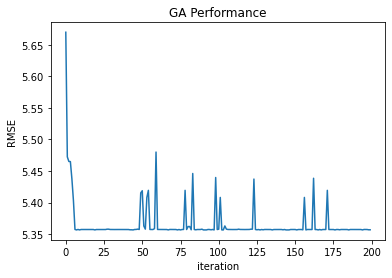

In [17]:
# Elitism 없는 성능 지표 : flucturation이 매우 심함
# 성능지표 간 절대적인 값 차이가 적기 때문에, 작은 변화로도 영향이 큼

plt.plot(performance)
plt.title("GA Performance")
plt.xlabel('iteration')
plt.ylabel('RMSE')

plt.show()